In [1]:
# standard libs
import os
import sys
import logging

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import utils
import dataset
import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
from prediction_type import TypeClassifier, TypeClassifierComparison
from preprocessing import *

# external libs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt

import shap

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier

/usr/local/Caskroom/miniconda/base/envs/uf-ml/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
%load_ext autoreload
%autoreload 2

## Data

In [6]:
path_data_france = os.path.join('..', 'data', 'france-cities-200.csv')
data_france = pd.read_csv(path_data_france)
data_france_sample = data_france.sample(frac=.1, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)

In [ ]:
path_data_netherlands = os.path.join('..', 'data', 'netherlands-cities-200.csv')
data_netherlands = pd.read_csv(path_data_netherlands)
data_netherlands_sample = data_netherlands.sample(frac=.1, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)

array([nan])

In [ ]:
xgb_params_optimal = {
    'max_depth': 10,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

## Preprocessing

In [8]:
data_france_sample['type_source'].unique()

array(['Résidentiel', 'Indifférencié', 'Annexe', 'Agricole',
       'Commercial et services', 'Industriel', 'Religieux', 'Sportif'],
      dtype=object)

<AxesSubplot:>

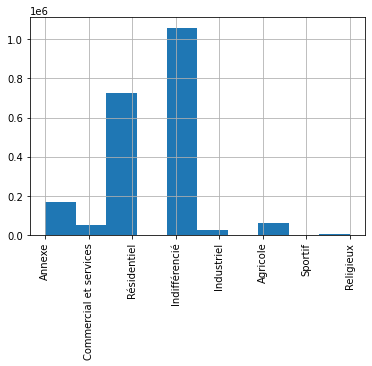

In [14]:
data_france['type_source'].hist(xrot=90)

## Baseline experiments

### Binary

In [10]:
classifier = TypeClassifier(
    model=XGBClassifier(),
    df=data_france_sample.sample(frac=0.01),
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_with_unknown_type],
    mitigate_class_imbalance=True,
    predict_probabilities=False,
)
# classifier.evaluate_classification()
a = np.array(classifier.calculate_SHAP_values()).shape
a = np.abs(classifier.calculate_SHAP_values()).mean(0)
b = np.abs(classifier.calculate_SHAP_values()).mean(axis=(0,1))
print(a.shape)
print(a.ndim)
print(a[0])
print(b.shape)
print(b.ndim)
print(b[0])

2022-03-09 10:23:03,159 | INFO : Dataset length: 2098
2022-03-09 10:23:03,163 | INFO : Training dataset length: 1678
2022-03-09 10:23:03,163 | INFO : Test dataset length: 420
2022-03-09 10:23:03,180 | INFO : Training dataset length after preprocessing: 831
2022-03-09 10:23:03,180 | INFO : Test dataset length after preprocessing: 209
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(119,)
1
0.75500005
()
0


IndexError: invalid index to scalar variable.

In [209]:
# classifier.feature_dependence_plot('FootprintArea', 'lat')
classifier.normalized_feature_importance()

,feature,normalized_importance
34,StdBlockFootprintArea,0.090171
33,AvBlockFootprintArea,0.075525
97,street_based_block_std_orientation_inter_buffe...,0.059773
35,BlockTotalFootprintArea,0.046637
14,av_footprint_area_within_buffer_100,0.045870
...,...,...
36,BlockPerimeter,0.000000
8,CountTouches,0.000000
89,street_based_block_area,0.000000
76,street_length_std_within_buffer_100,0.000000



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(119,)
1.2314234


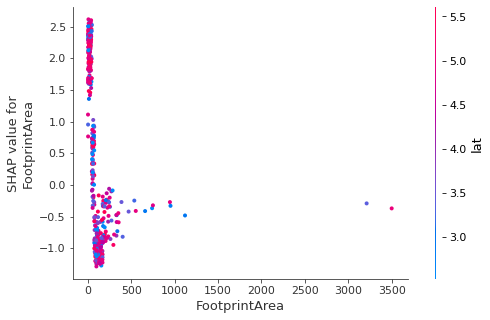

In [240]:
classifier = TypeClassifier(
    model=XGBClassifier(),
    df=data_france_sample.sample(frac=0.01),
    cross_validation_split=split_80_20,
    preprocessing_stages=[group_non_residential_buildings],
    mitigate_class_imbalance=True,
    predict_probabilities=False,
)
# classifier.evaluate_classification()
np.array(classifier.calculate_SHAP_values()).shape
a = np.abs(classifier.calculate_SHAP_values()).mean(0)
print(a.shape)
print(a[0])
classifier.feature_dependence_plot('FootprintArea', 'lat')



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is depreca

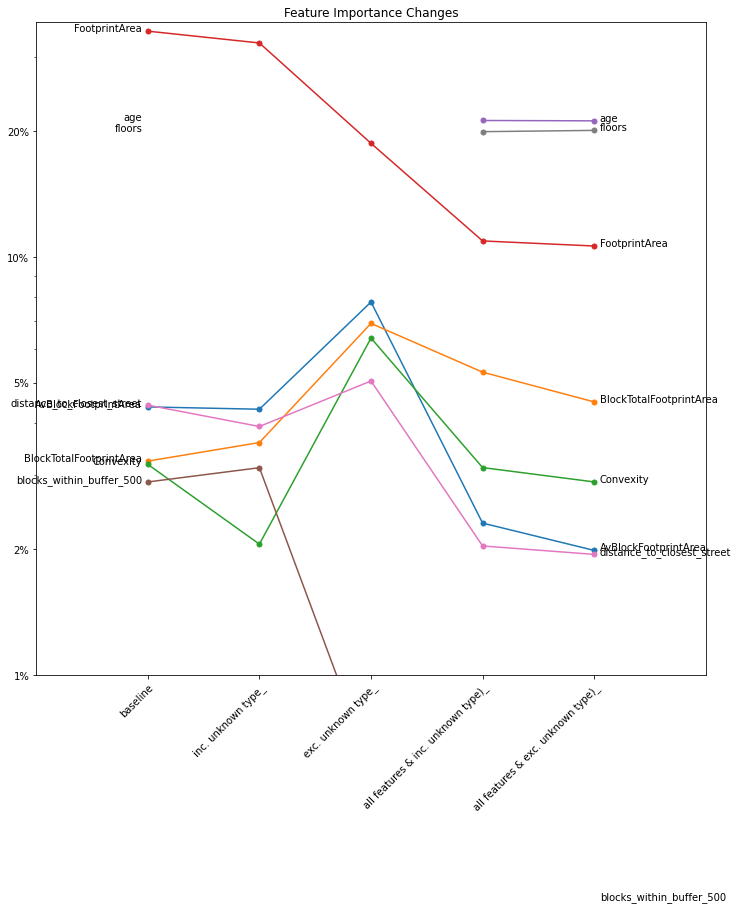

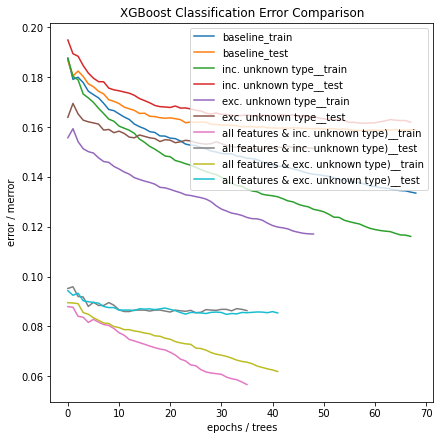

,name,MCC,F1,Recall_res,Recall_non-res
2,exc. unknown type_,0.650675,0.824973,0.877815,0.783187
1,inc. unknown type_,0.669722,0.829121,0.879692,0.816773
0,baseline,0.676877,0.832606,0.885343,0.818394
3,all features & inc. unknown type)_,0.796493,0.898178,0.943978,0.846896
4,all features & exc. unknown type)_,0.799569,0.899760,0.942050,0.854258


In [149]:
logging.disable(logging.WARN)

# ensure different classification tests are conducted with equally sized training samples
ratio = len(remove_buildings_with_unknown_type(data_france_sample)) / len(data_france_sample)

grid_comparison_config = {
    'class weights': {'mitigate_class_imbalance': True},
    'class imbalance': {'mitigate_class_imbalance': False},
    'predict probabilities': {'predict_probabilities': True},
    'predict classes': {'predict_probabilities': False},
}

comparison_config = {
    'inc. unknown type': {'preprocessing_stages': [group_non_residential_buildings], 'df': data_france_sample.sample(frac=ratio, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)},
    'exc. unknown type': {'preprocessing_stages': [remove_buildings_with_unknown_type, group_non_residential_buildings]},
    'all features & inc. unknown type)': {'preprocessing_stages': [remove_buildings_with_unknown_type, group_non_residential_buildings], 'df': data_france_sample.sample(frac=ratio, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)},
    'all features & exc. unknown type)': {'preprocessing_stages': [remove_buildings_with_unknown_type, remove_buildings_with_unknown_type, group_non_residential_buildings]},
}

comparison_type_prediction = TypeClassifierComparison(
    model=XGBClassifier(),
    df=data_france_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[group_non_residential_buildings],
    comparison_config=comparison_config,
    # grid_comparison_config=grid_comparison_config,
    predict_probabilities=False,
    mitigate_class_imbalance=True,
    compare_feature_importance=True,
)
comparison_type_prediction.plot_feature_importance_changes()
comparison_type_prediction.evaluate()

### Multiclass

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limi

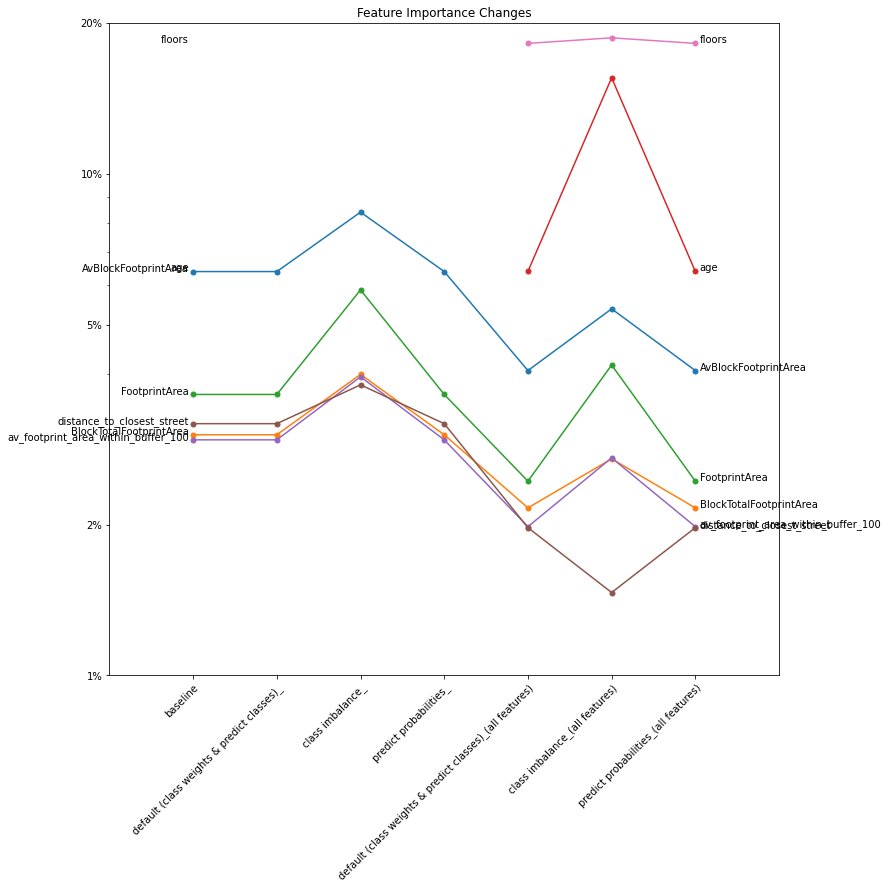

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
Note that pos_label (set to 2) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
Note that pos_label (set to 4) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
Note that pos_label (set to 5) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
Note that pos_label (set to 6) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_

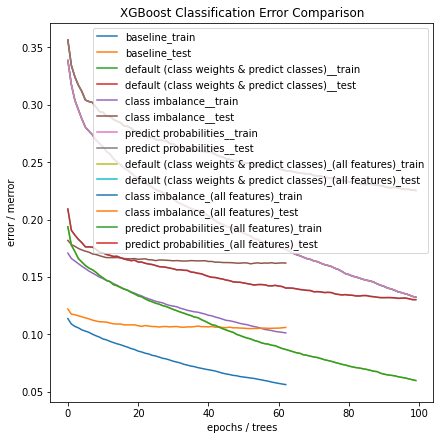

,name,MCC,F1,Recall_Résidentiel,Recall_Annexe,Recall_Agricole,Recall_Commercial et services,Recall_Industriel,Recall_Religieux,Recall_Sportif
3,predict probabilities_,0.523329,0.525408,0.841935,0.742227,0.595214,0.681188,0.432432,0.679030,0.178571
0,baseline,0.586124,0.598145,0.844355,0.723007,0.485543,0.738614,0.378378,0.805567,0.250000
1,default (class weights & predict classes)_,0.586124,0.598145,0.844355,0.723007,0.485543,0.738614,0.378378,0.805567,0.250000
2,class imbalance_,0.642348,0.564101,0.763710,0.609384,0.217348,0.645545,0.243243,0.955104,0.142857
6,predict probabilities_(all features),0.702823,0.681791,0.924194,0.834370,0.591226,0.685149,0.675676,0.857922,0.250000
4,default (class weights & predict classes)_(all...,0.740491,0.698785,0.925806,0.818542,0.521436,0.734653,0.702703,0.908344,0.250000
5,class imbalance_(all features),0.774338,0.673237,0.928226,0.750424,0.381854,0.667327,0.567568,0.974030,0.142857


In [12]:
logging.disable(logging.WARN)

# ensure different classification tests are conducted with equally sized training samples
ratio = len(remove_buildings_with_unknown_type(data_france_sample)) / len(data_france_sample)

grid_comparison_config = {
    '': {'preprocessing_stages': []},
    '(all features)': {'preprocessing_stages': []},
}

comparison_config = {
    'default (class weights & predict classes)': {'mitigate_class_imbalance': True, 'predict_probabilities': False},
    'class imbalance': {'mitigate_class_imbalance': False},
    'predict probabilities': {'predict_probabilities': True},
}

comparison_type_prediction = TypeClassifierComparison(
    model=XGBClassifier(),
    df=data_france_sample,
    test_training_split=split_80_20,
    preprocessing_stages=[],
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
    predict_probabilities=False,
    mitigate_class_imbalance=True,
    compare_feature_importance=True,
    binary=False
)
comparison_type_prediction.plot_feature_importance_changes()
comparison_type_prediction.evaluate()

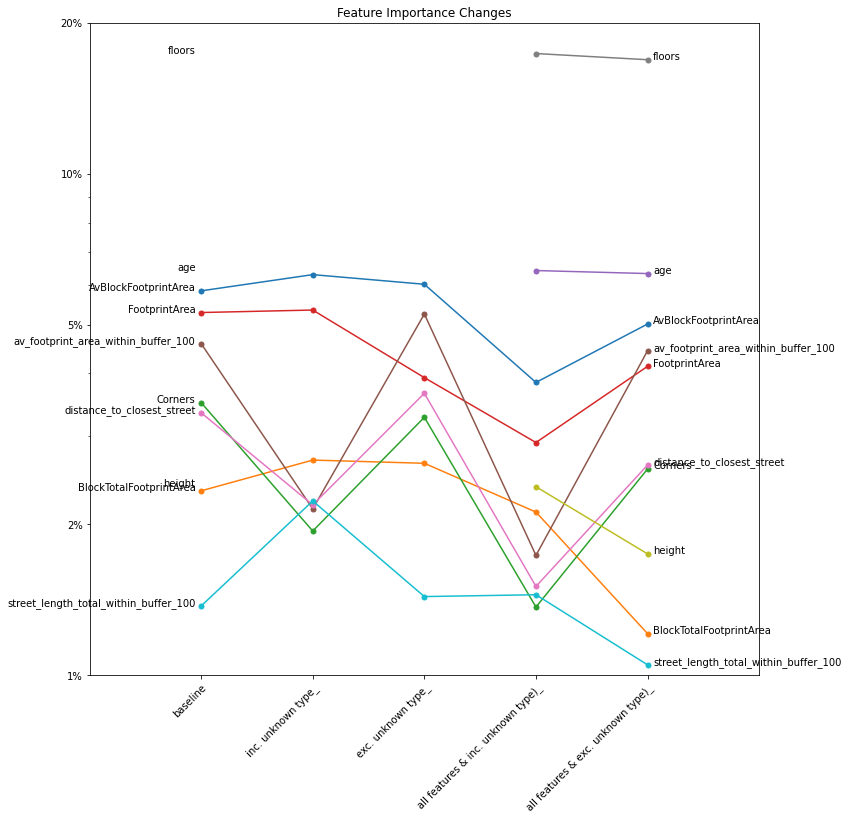

Note that pos_label (set to 0) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
Note that pos_label (set to 2) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
Note that pos_label (set to 4) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
Note that pos_label (set to 5) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
Note that pos_label (set to 6) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
Note that pos_label (set to 7) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_

KeyError: 'error'

In [214]:
comparison_type_prediction.plot_feature_importance_changes()
comparison_type_prediction.evaluate()

## Other experiments

In [67]:
# evals_result() returns evaluation results from last xgb training (static)
print(list(comparison_type_prediction.predictors.values())[0].model.evals_result()['validation_0']['logloss'][:10])
print(list(comparison_type_prediction.predictors.values())[1].model.evals_result()['validation_0']['logloss'][:10])
print(list(comparison_type_prediction.predictors.values())[2].model.evals_result()['validation_0']['logloss'][:10])

print(list(comparison_type_prediction.predictors.values())[2].evals_result['validation_0']['logloss'][:10])

[0.553267, 0.474377, 0.422126, 0.387219, 0.361832, 0.341795, 0.325963, 0.314875, 0.305448, 0.295921]
[0.553267, 0.474377, 0.422126, 0.387219, 0.361832, 0.341795, 0.325963, 0.314875, 0.305448, 0.295921]
[0.553267, 0.474377, 0.422126, 0.387219, 0.361832, 0.341795, 0.325963, 0.314875, 0.305448, 0.295921]
[0.553267, 0.474377, 0.422126, 0.387219, 0.361832, 0.341795, 0.325963, 0.314875, 0.305448, 0.295921]


              precision    recall  f1-score   support

         res       0.90      0.97      0.94      1373
     non-res       0.99      0.95      0.97      2823

    accuracy                           0.96      4196
   macro avg       0.95      0.96      0.95      4196
weighted avg       0.96      0.96      0.96      4196

Cohen’s kappa: 0.9065863967300382


FixedFormatter should only be used together with FixedLocator


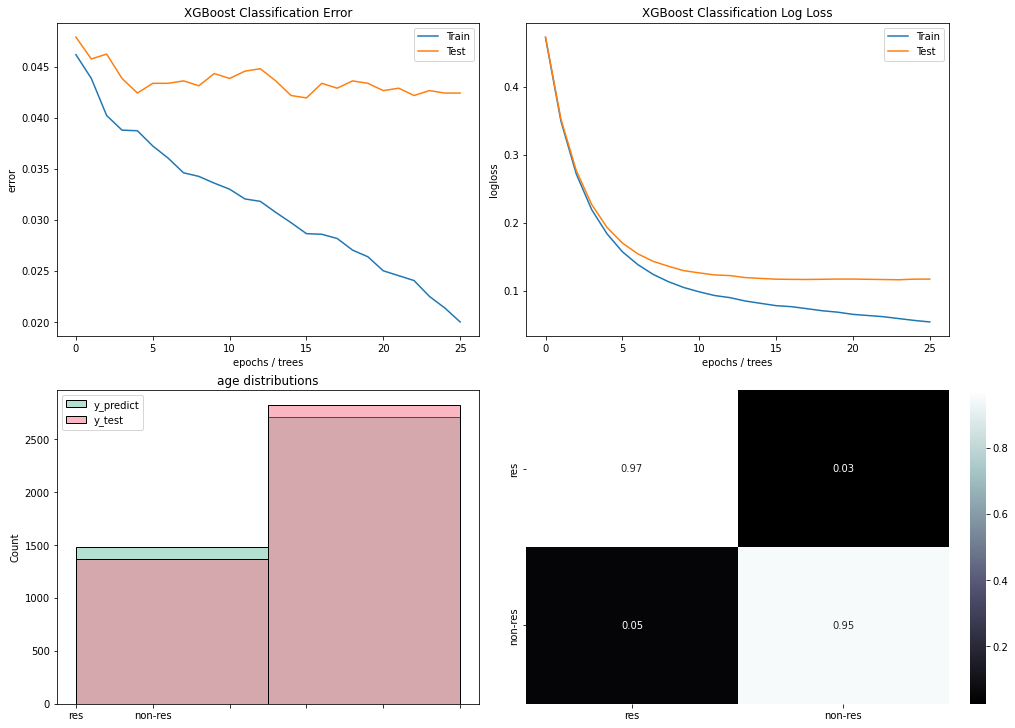

In [91]:
classifier.evaluate_classification()

In [103]:
classifier.print_feature_importance()

                                      importance
FootprintArea                        2129.090088
blocks_within_buffer_500              989.350464
buildings_within_buffer_100           548.469299
av_footprint_area_within_buffer_100   492.000488
AvBlockFootprintArea                  489.307526
BlockTotalFootprintArea               333.083954
BlockLength                           303.528473
Corners                               302.899902
blocks_2_to_4                         290.934021
distance_to_closest_street            234.543640
buildings_within_buffer_500           231.558228
CountTouches                          164.213470
blocks_5_to_9                         155.134552
StdBlockFootprintArea                 140.811661
Convexity                             137.198700


In [114]:
classifier_w_age.print_feature_importance()

                                              importance
age                                           603.832764
FootprintArea                                 291.799225
floors                                        244.594971
BlockTotalFootprintArea                       229.903366
Convexity                                      65.565521
av_block_footprint_area_within_buffer_100      51.519737
height                                         41.706936
av_block_av_footprint_area_within_buffer_100   40.600719
Elongation                                     39.212143
std_footprint_area_within_buffer_100           38.367317
AvBlockFootprintArea                           36.431385
distance_to_closest_street                     36.337280
street_based_block_number_inter_buffer_500     33.152710
av_footprint_area_within_buffer_100            31.866264
Corners                                        24.906160


### Deprecated: Still considers Indifférencié buildings

In [ ]:
logging.disable(logging.WARN)

# ensure different classification tests are conducted with equally sized training samples
ratio = len(remove_buildings_with_unknown_type(data_france_sample)) / len(data_france_sample)

grid_comparison_config = {
    'class weights': {'mitigate_class_imbalance': True},
    'class imbalance': {'mitigate_class_imbalance': False},
    'predict probabilities': {'predict_probabilities': True},
    'predict classes': {'predict_probabilities': False},
}

comparison_config = {
    # 'inc. unknown type': {'preprocessing_stages': [], 'df': data_france_sample.sample(frac=ratio, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)},
    '': {'preprocessing_stages': [remove_buildings_with_unknown_type]},
    # 'all features & inc. unknown type)': {'preprocessing_stages': [], 'df': data_france_sample.sample(frac=ratio, random_state=dataset.GLOBAL_REPRODUCIBILITY_SEED)},
    'all features': {'preprocessing_stages': [remove_buildings_with_unknown_type]},
}

comparison_type_prediction = TypeClassifierComparison(
    model=XGBClassifier(),
    df=data_france_sample.sample(frac=.1),
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_with_unknown_type],
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
    predict_probabilities=False,
    mitigate_class_imbalance=True,
    compare_feature_importance=True,
    binary=False
)
comparison_type_prediction.plot_feature_importance_changes()
comparison_type_prediction.evaluate()